# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [33]:
import numpy as np
import os

from matplotlib import pyplot as plt

from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

The code below can is compacted with the function ```create_truth```
```
  
# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

t_max = 7.
i1 = np.argmin(abs(t_true - t_max))
y_true, y_raw, t_true = [xx[:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Select the observations time-window
t_start = 2. * Annular.t_transient
t_stop = t_start + Annular.t_CR * 20
Nt_obs = 60

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]
```

The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, t_obs=t_obs, y_obs=y_obs, 
     dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

In [34]:
2. * Annular.t_transient + Annular.t_CR * 20,

(1.2,)

In [35]:
from essentials.create import create_truth
ER = 0.5625 # 0.4875 + np.arange(0, 4) * 0.025
truth_params = dict(model = data_folder + 'annular/ER_{}'.format(ER),
                    t_start = 2. * Annular.t_transient,
                    t_stop = 2. * Annular.t_transient + Annular.t_CR * 40,
                    Nt_obs = 60,
                    t_max = 7.,
                    post_processed=False
                    )

truth = create_truth(**truth_params)

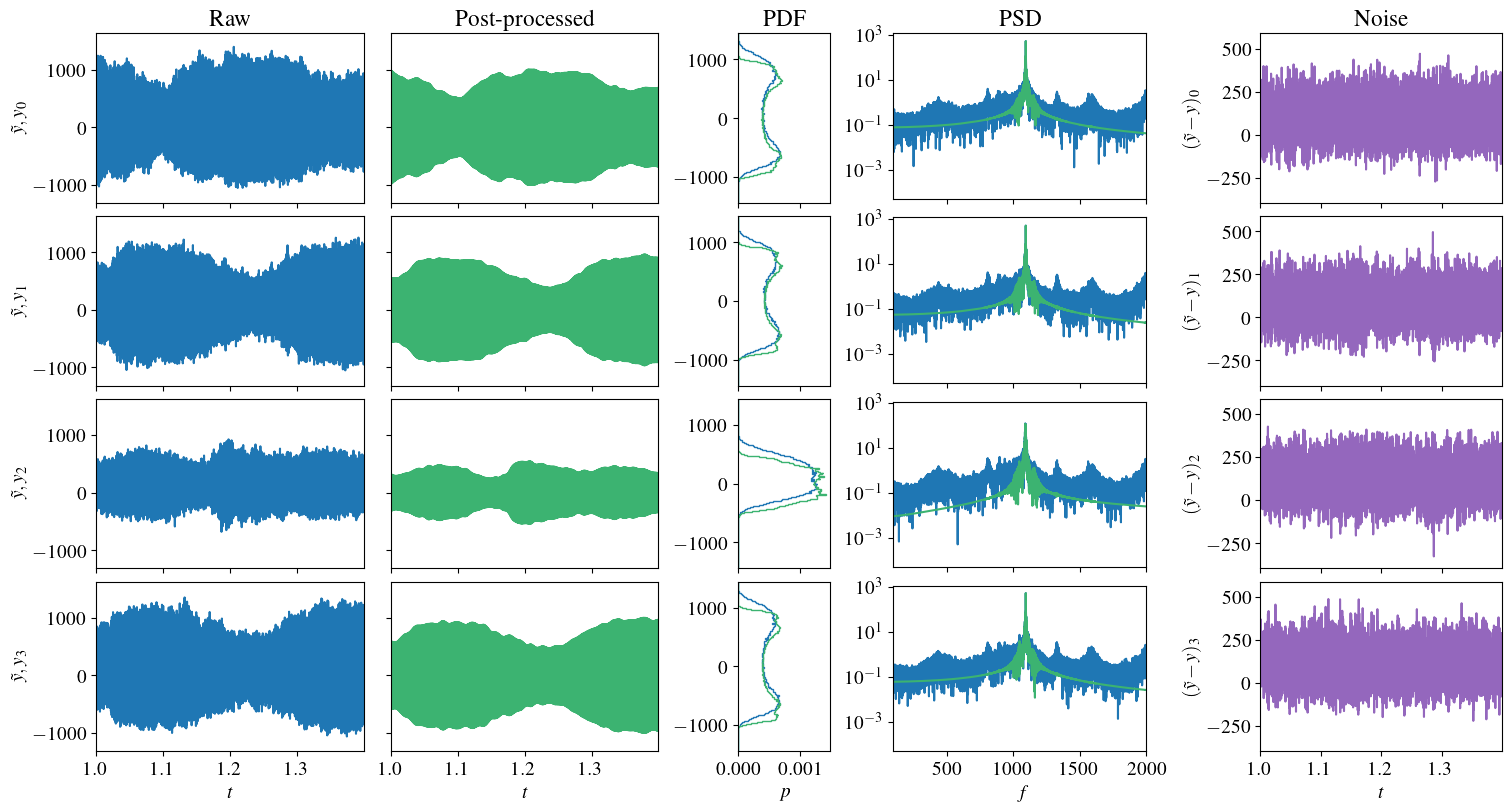

In [36]:
from essentials.plotResults import plot_truth
plot_truth(**truth)

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [37]:
Annular.nu_from_ER(ER)

25.105625000000032

In [38]:
alpha0 = dict(nu=(20., 40.),
              c2beta=(10, 50),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(0.0001, 0.03),
              omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.0,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)



Visualize ensemble initialization

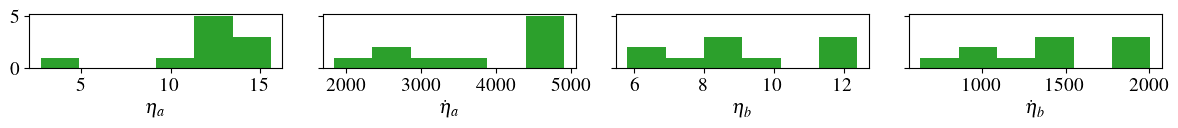

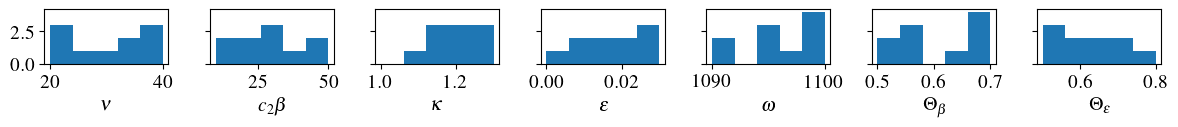

In [39]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [40]:
from essentials.create import create_bias_training_dataset

ensemble_no_bias = ensemble.copy()
ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=5,
                    t_train=ensemble.t_CR * 10,
                    t_test=ensemble.t_CR * 2,
                    t_val=ensemble.t_CR * 2,
                    # Training data generation options
                    augment_data=True,
                    bayesian_update=False,
                    biased_observations=True,
                    seed_W=0,
                    L=10,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-12, 1e-9]
                    )

ensemble_ESN.init_bias(**train_params)


|
**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [41]:
train_data = create_bias_training_dataset(truth['y_raw'], truth['y_true'], ensemble_ESN, **train_params)


Visualize training data


In [42]:
#TODO

print(train_data['data'].shape,
      train_data['observed_idx'],
      )

(30, 11269, 8) [4 5 6 7]



**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.


 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-09	 -5.4233
2	 5.000e-01	 1.000e-03	 1.000e-12	 -5.4499
3	 5.000e-01	 1.000e-01	 1.000e-09	 -5.3141
4	 5.000e-01	 1.000e+01	 1.000e-09	 -3.5458
5	 6.667e-01	 1.000e-05	 1.000e-09	 -5.3238
6	 6.667e-01	 1.000e-03	 1.000e-12	 -5.4036
7	 6.667e-01	 1.000e-01	 1.000e-12	 -5.3620
8	 6.667e-01	 1.000e+01	 1.000e-09	 -4.1923
9	 8.333e-01	 1.000e-05	 1.000e-12	 -5.2495
10	 8.333e-01	 1.000e-03	 1.000e-09	 -5.3208
11	 8.333e-01	 1.000e-01	 1.000e-12	 -5.3769
12	 8.333e-01	 1.000e+01	 1.000e-09	 -4.5472
13	 1.000e+00	 1.000e-05	 1.000e-12	 -5.2630
14	 1.000e+00	 1.000e-03	 1.000e-09	 -5.3373
15	 1.000e+00	 1.000e-01	 1.000e-12	 -5.2026
16	 1.000e+00	 1.000e+01	 1.000e-09	 -4.1610
17	 5.000e-01	 5.508e-04	 1.000e-12	 -5.4494
18	 5.027e-01	 1.360e-02	 1.000e-09	 -5.2178
19	 9.372e-01	 1.091e-02	 1.000e-09	 -5.3391
20	 5.000e

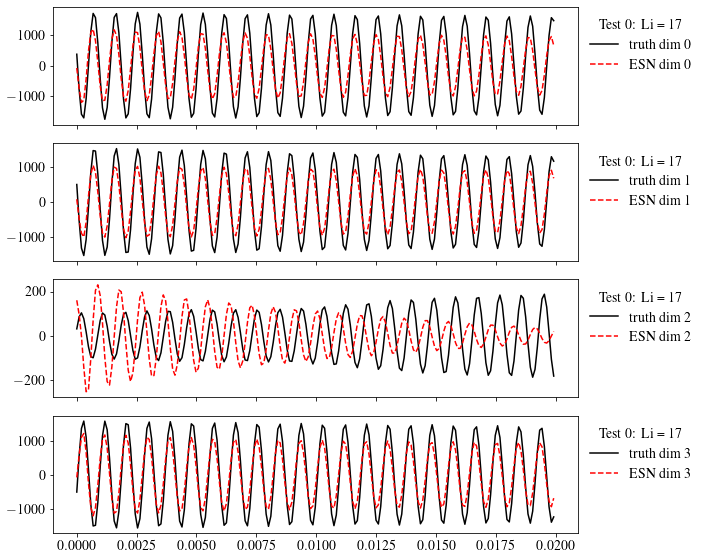

In [43]:
ensemble_ESN.bias.train_bias_model(**train_data)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from essentials.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

In [44]:
ensemble_ESN.bias.t_init = truth['t_obs'][0] - 2 * truth['dt_obs']

i1 = np.argmin(abs(ensemble_ESN.bias.t_init - truth['t']))
i0 = i1 - ensemble_ESN.bias.N_wash  * ensemble_ESN.bias.upsample 

wash_obs = truth['y_raw'][i0:i1 + 1:ensemble_ESN.bias.upsample]
wash_t = truth['t'][i0:i1 + 1:ensemble_ESN.bias.upsample]


## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [54]:
from essentials.DA import dataAssimilation

DA_kwargs = dict(y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=0.1, wash_obs=wash_obs, wash_t=wash_t)

ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 5.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_ESN, ensemble_no_bias]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = truth['t_obs'][0]
    ens.inflation = 1.01
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 5
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 30.0
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = 30.0
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ---------------- ESN bias model parameters --------------- 
	 L = 10
	 N_ens = 1
	 N_units = 50
	 N_wash = 5
	 bayesian_update = False
	 biased_observations = True
	 connect = 3
	 observed_idx = [4 5 6 7]
	 perform_test = True
	 rho = 0.5
	 sigma_in = 0.001
	 t_train = 0.1
	 t_val = 0.02
	 tikh = 1e-12
	 update_reservoir = False
	 upsample = 5

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.01 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (20.0, 40.0), 'c2beta': (10, 50), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'o

            omega         nu           c2beta       kappa            epsilon          theta_b       theta_e
----------  ------------  -----------  -----------  ---------------  ---------------  ------------  -------------
Truth       $6848.672$    $25.105625$  $37.02375$   $0.00012$        $0.0023$         $0.63$        $0.66$
rBA_EnKF    $6862.2444    $22.947088   $16.921915   $0.00011983143   $0.0069698551    $0.53994345   $0.60247416
 w/ ESN      \pm 0.3449$   \pm 2.119$   \pm 2.653$   \pm 5.73e-06$    \pm 0.0002921$   \pm 0.106$    \pm 0.05695$
EnSRKF      $6861.8156    $29.16922    $23.140073   $0.00013103558   $0.007106866     $0.68678116   $0.55883858
 w/ NoBias   \pm 0.6221$   \pm 4.283$   \pm 5.257$   \pm 1.119e-05$   \pm 0.0005988$   \pm 0.1009$   \pm 0.06956$


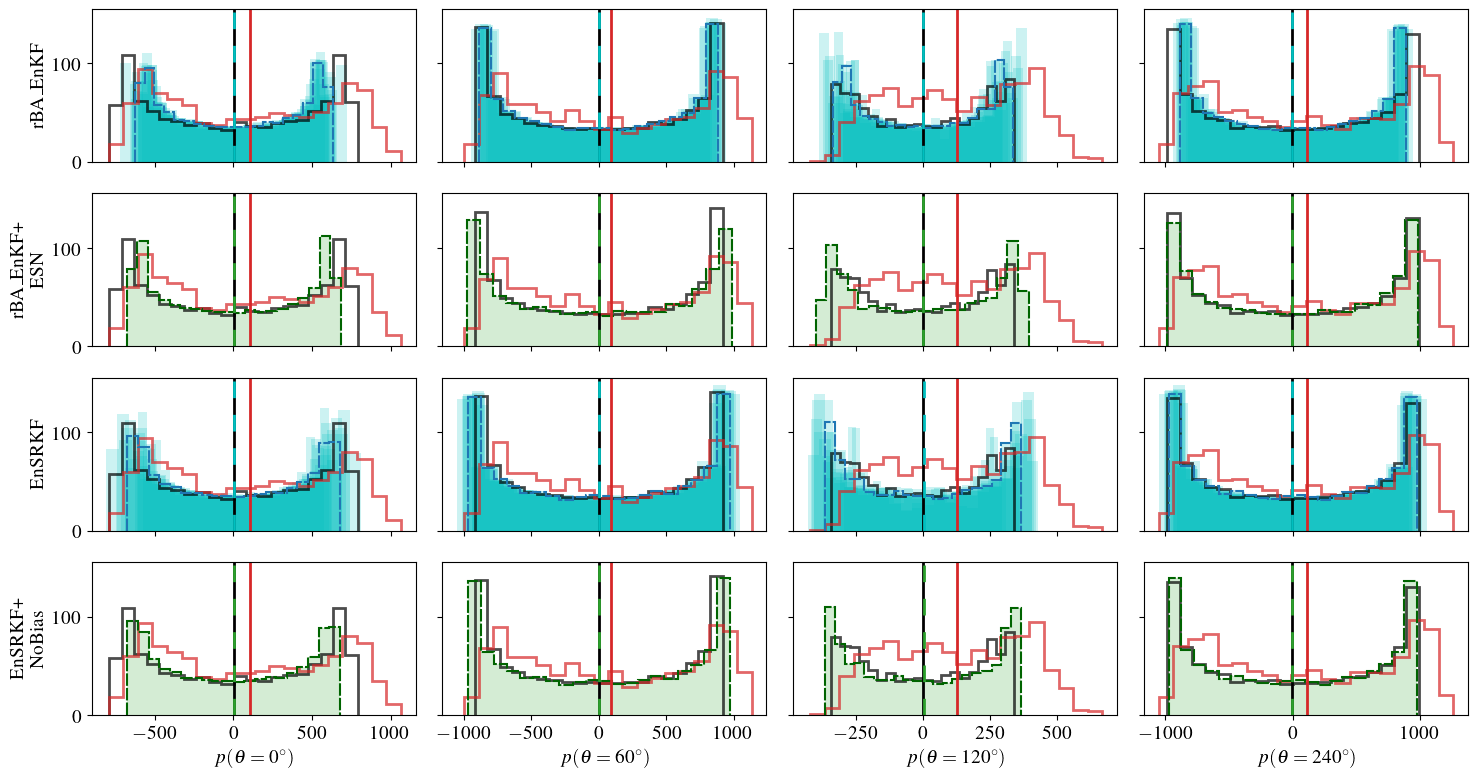

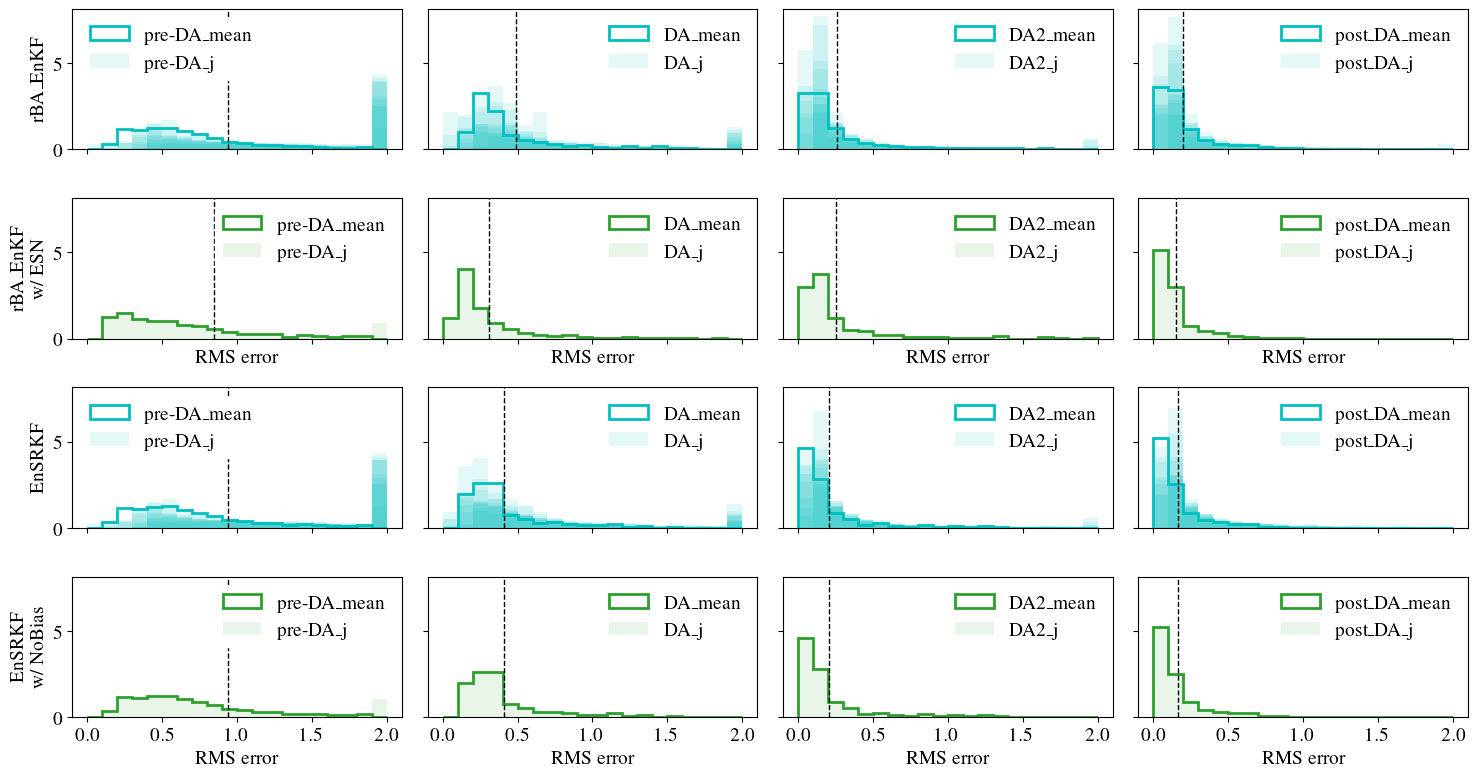

In [55]:
from essentials.plotResults import print_parameter_results
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

truth_params = dict()
for param in Annular.params:
    if param == 'nu':
        truth_params[param] = Annular.nu_from_ER(ER)
    elif param == 'c2beta':
        truth_params[param] = Annular.c2beta_from_ER(ER)
    else:
        truth_params[param] = Annular.defaults[param]

print_parameter_results(out, true_values=truth_params)
               
truth['wash_t'] = wash_t
truth['wash_obs'] = wash_obs

window = (truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 2)
plot_states_PDF(out, truth, nbins=20, window=window)
plot_RMS_pdf(out, truth, nbins=20)

[-1349.5854988993158, 1349.5854988993158]
[-1349.5854988993158, 1349.5854988993158]


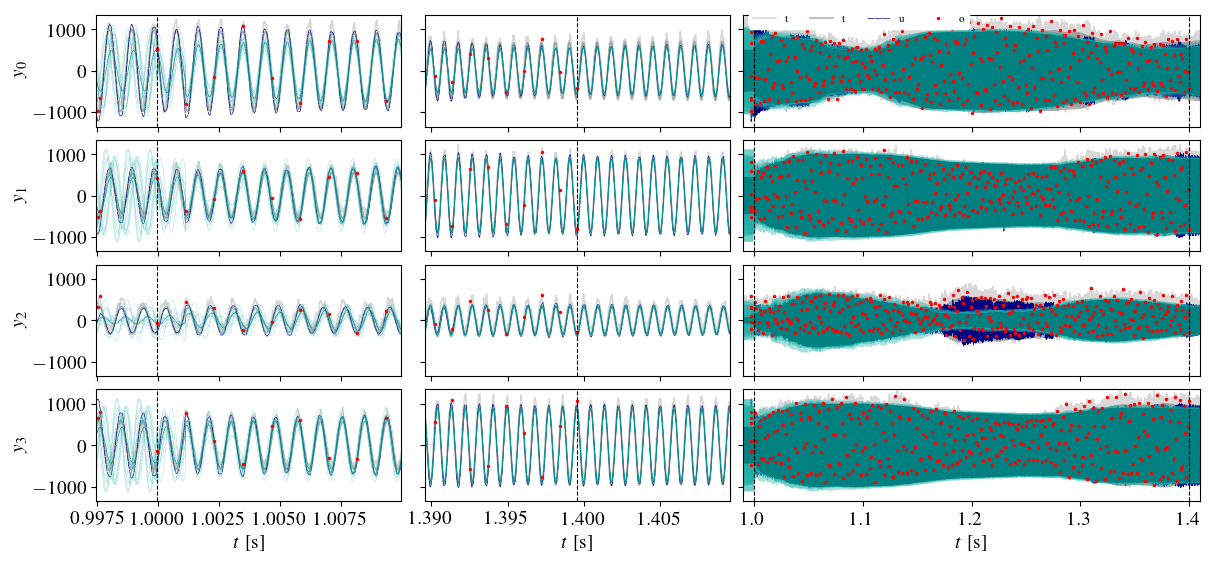

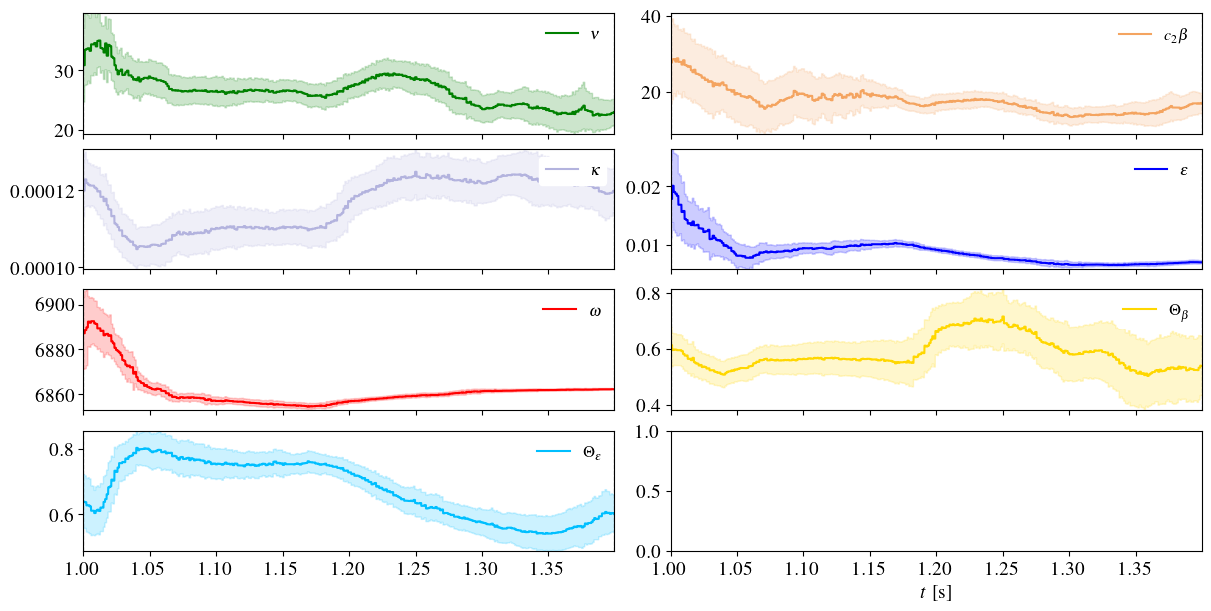

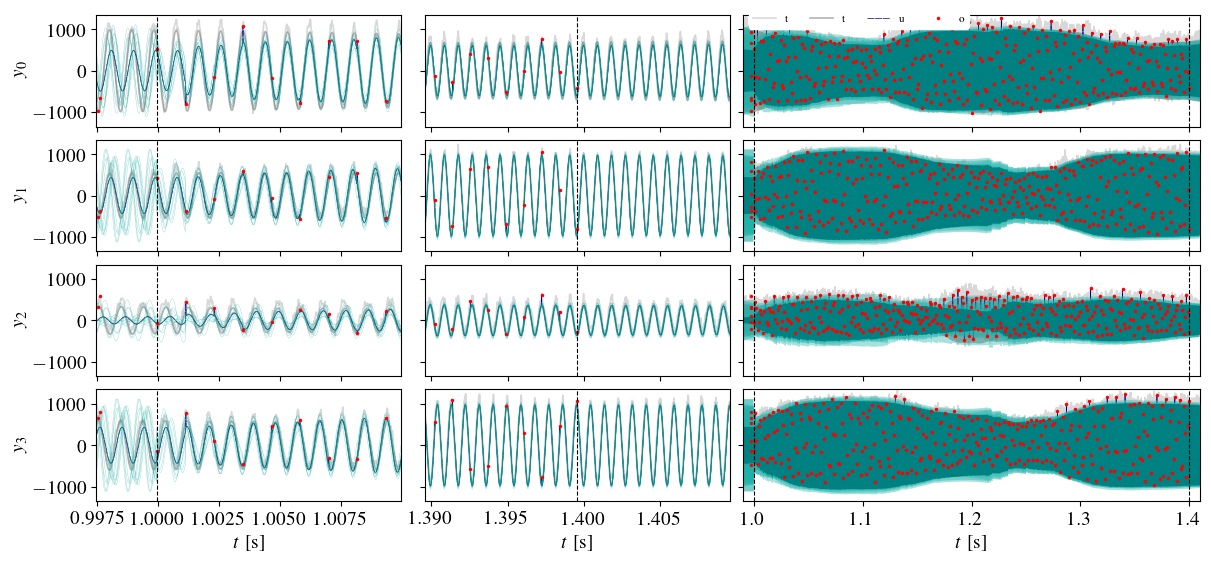

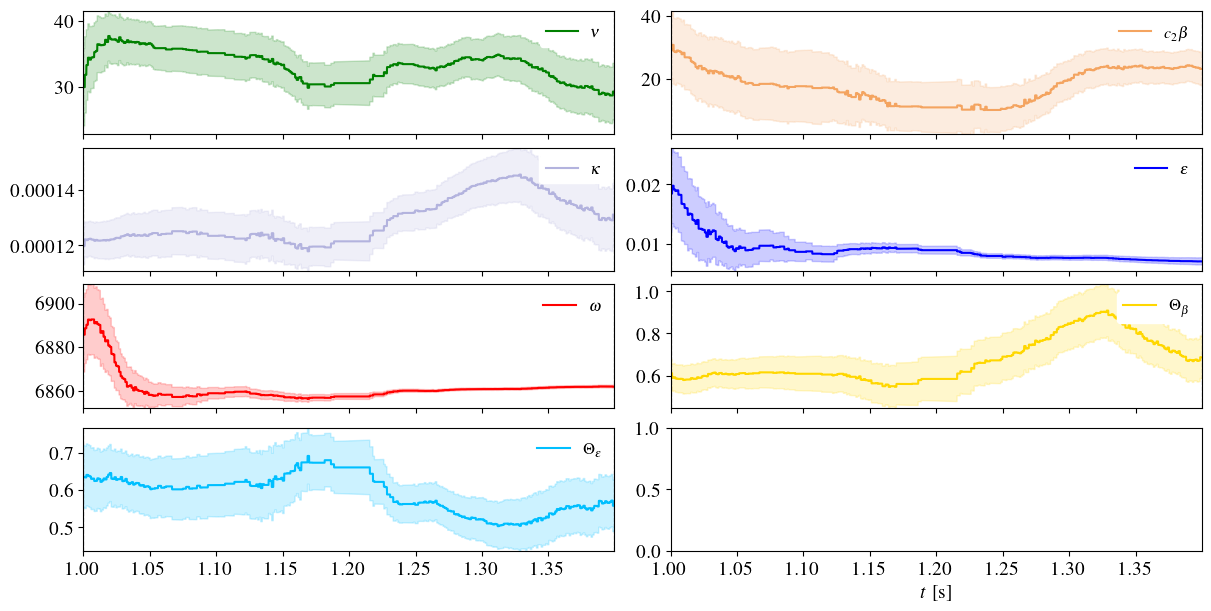

In [56]:
from essentials.plotResults import plot_timeseries, plot_parameters

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)

In [79]:
import matplotlib.pyplot as plt#

%matplotlib widget

for filter_ens in [out[0]]:
    bias = filter_ens.bias
    ESN_prediction = bias.hist
    bias_hist = bias.get_bias(ESN_prediction)
    inn_hist = ESN_prediction[:, bias.observed_idx]
    
    fig, axs = plt.subplots(bias.N_dim_in, 1, sharex=True, sharey=True)
    for kk, ax in enumerate(axs):
        ax.plot(bias.hist_t, bias_hist[:, kk])
        ax.plot(bias.hist_t, inn_hist[:, kk])
        ax.plot(bias.hist_t, bias_hist[:, kk] - inn_hist[:, kk])
    ax.set_xlim([DA_kwargs['wash_t'][0], bias.hist_t[-1]])
    
    

<IPython.core.display.Javascript object>